In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **DATA LOADING**

In [2]:
def load_data():
  return pd.read_csv('/content/drive/MyDrive/Sales_Prediction/Data/train.csv')

sales_data = load_data()
sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
def monthly_sales(data):    
    data = data.copy()         
    data.date = data.date.apply(lambda x: str(x)[:-3])         
    data = data.groupby('date')['sales'].sum().reset_index()    
    data.date = pd.to_datetime(data.date)  
    data.to_csv('/content/drive/MyDrive/Sales_Prediction/Data/monthly_data.csv')     
    return data

monthly_data = monthly_sales(sales_data)
monthly_data.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


# **EXPLORING DATA**

In [4]:
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(f'Total Number of Days: {number_of_days.days} days')
    print(f'Total Years: {number_of_years} years')
    
sales_duration(sales_data)

Total Number of Days: 1825 days
Total Years: 5.0 years


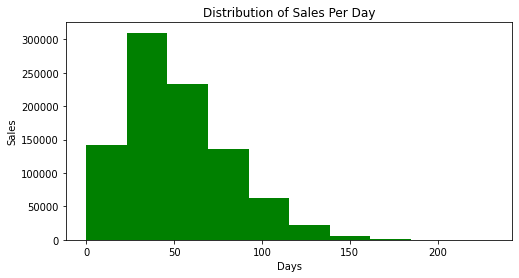

In [5]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(8,4))
    plt.hist(sales_data.sales, color='green')
    
    ax.set(xlabel = "Days",
           ylabel = "Sales",
           title = "Distribution of Sales Per Day")
    
sales_per_day()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


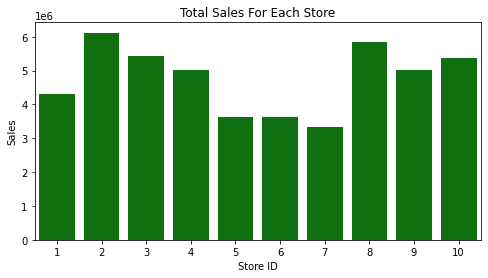

In [6]:
def sales_per_store():
    by_store = sales_data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(by_store.store, by_store.sales, color='green')
    
    ax.set(xlabel = "Store ID",
           ylabel = "Sales",
           title = "Total Sales For Each Store")
    
sales_per_store()

In [7]:
avg_monthly_sales = monthly_data.sales.mean()
print(f'Overall average monthly sales: ${avg_monthly_sales}')

avg_monthly_sales_last_year = monthly_data.sales[-12:].mean()
print(f"Last year's average monthly sales: ${avg_monthly_sales_last_year}")

Overall average monthly sales: $795075.2
Last year's average monthly sales: $894478.3333333334


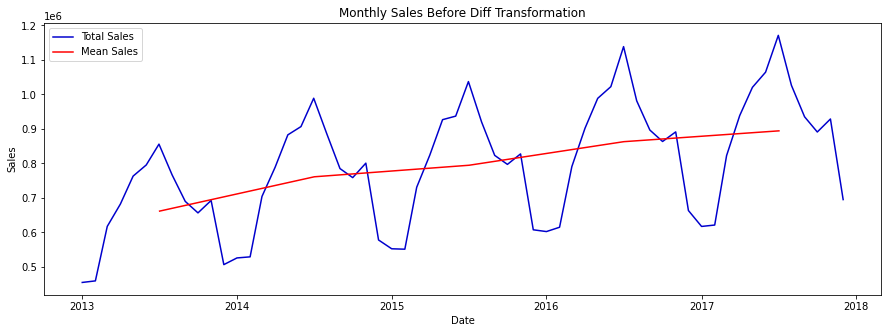

In [8]:
warnings.filterwarnings("ignore")

def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)

time_plot(monthly_data, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

In [9]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()    
    data = data.dropna()      
    return data

stationary_df = get_diff(monthly_data)
stationary_df.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


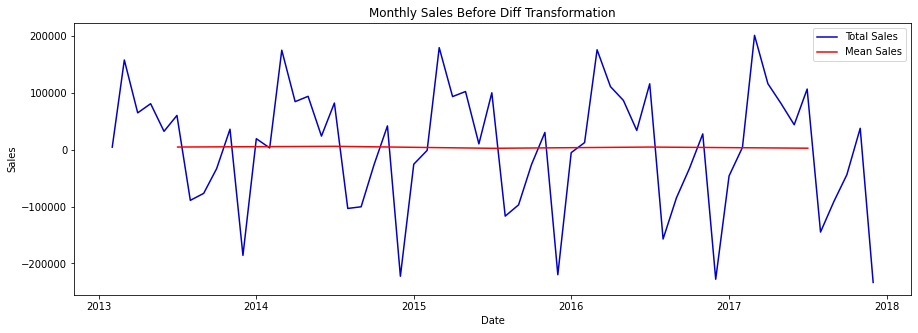

In [10]:
time_plot(monthly_data, 'date', 'sales_diff', 'Monthly Sales Before Diff Transformation')

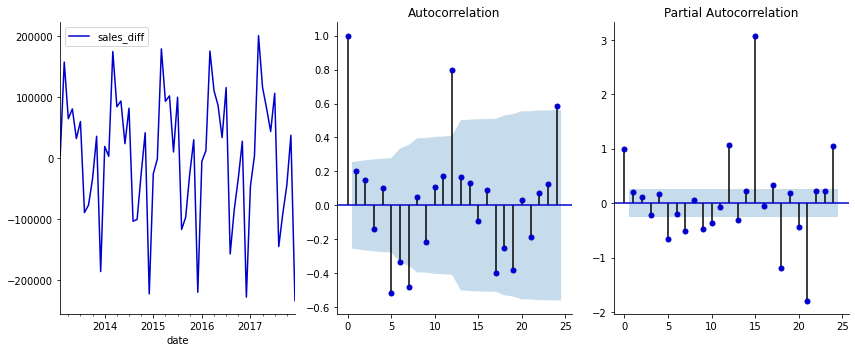

In [11]:
def plots(data, lags=None):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()


plots(stationary_df, lags=24);

In [12]:
def generate_supervised(data):
    supervised_df = data.copy()
    
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    supervised_df.to_csv('/content/drive/MyDrive/Sales_Prediction/Data/model_df.csv', index=False)
    return supervised_df

model_df = generate_supervised(stationary_df)
model_df.head()

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [13]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('/content/drive/MyDrive/Sales_Prediction/Data/model_df.csv')
    return dt_data

datetime_df = generate_arima_data(stationary_df)
datetime_df.to_csv('/content/drive/MyDrive/Sales_Prediction/Data/arima.csv')
datetime_df.head()

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0


#**Modeling Functions**

In [14]:
def split(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data[0:-12].values, data[-12:].values
    return train, test

train, test = split(model_df)

In [15]:
print(f"The train data shape is: {train.shape}")
print(f"The test data shape is: {test.shape}")

The train data shape is: (35, 13)
The test data shape is: (12, 13)


In [16]:
def scale_data(train_set, test_set):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [17]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [18]:
def predict_df(unscaled_predictions, original_df):
    result_list = []
    sales_dates = list(monthly_data[-13:].date)
    act_sales = list(monthly_data[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result


In [19]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [20]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    sns.despine()
    
    plt.savefig(f'/content/drive/MyDrive/Sales_Prediction/Result_Images/{model_name}_forecast.png')

In [21]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, monthly_data)
      
    get_scores(unscaled_df, monthly_data, model_name)
    plot_results(unscaled_df, monthly_data, model_name)

# **Linear Regression**

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


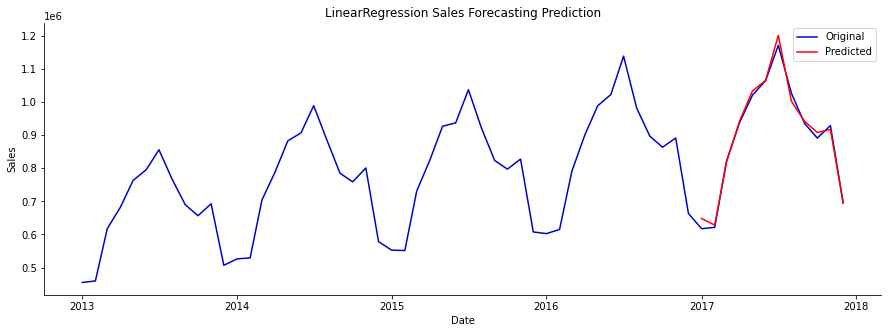

In [22]:
run_model(train, test, LinearRegression(), 'LinearRegression')

# **Long Short Term Memory**

In [23]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False)

    predictions = model.predict(X_test,batch_size=1)
    
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, monthly_data)

    get_scores(unscaled_df, monthly_data, 'LSTM')
    plot_results(unscaled_df, monthly_data, 'LSTM')

Epoch 1/200
35/35 [==============================] - 2s 1ms/step - loss: 0.2938
Epoch 2/200
35/35 [==============================] - 0s 1ms/step - loss: 0.2825
Epoch 3/200
35/35 [==============================] - 0s 1ms/step - loss: 0.2760
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 0.2686
Epoch 5/200
35/35 [==============================] - 0s 2ms/step - loss: 0.2599
Epoch 6/200
35/35 [==============================] - 0s 2ms/step - loss: 0.2495
Epoch 7/200
35/35 [==============================] - 0s 1ms/step - loss: 0.2371
Epoch 8/200
35/35 [==============================] - 0s 1ms/step - loss: 0.2230
Epoch 9/200
35/35 [==============================] - 0s 1ms/step - loss: 0.2075
Epoch 10/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1912
Epoch 11/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1746
Epoch 12/200
35/35 [==============================] - 0s 1ms/step - loss: 0.1583
Epoch 13/200
35/35 [=================

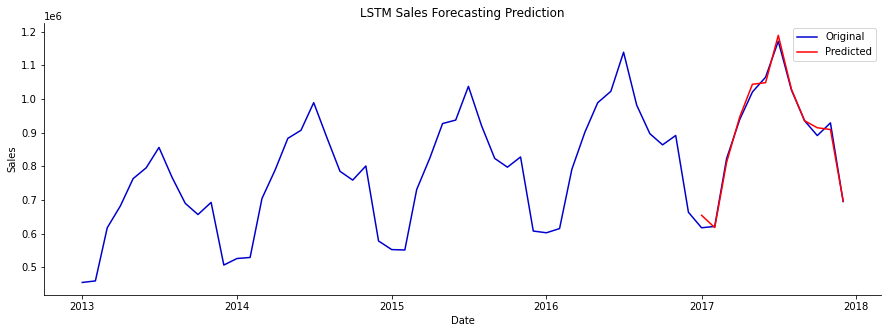

In [24]:
lstm_model(train, test)

In [25]:
pickle.dump(model_scores, open( "/content/drive/MyDrive/Sales_Prediction/model_scores.p", "wb" ))

In [26]:
def load_sarima_data():
    return pd.read_csv('/content/drive/MyDrive/Sales_Prediction/Data/arima.csv').set_index('date')

ts_data = load_sarima_data()
ts_data.index = pd.to_datetime(ts_data.index)
ts_data.head()

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0


In [27]:
def get_sarima_scores(data):
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "/content/drive/MyDrive/Sales_Prediction/arima_model_scores.p", "wb" ))


RMSE: 14959.8934671206
MAE: 11265.335748446343
R2 Score: 0.9835642876215278


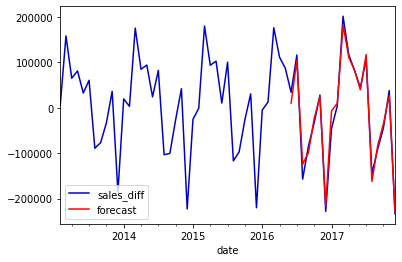

In [28]:
def sarimax_model(data):
    sar = sm.tsa.statespace.SARIMAX(ts_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red']) 
    get_sarima_scores(data)
    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)

In [29]:
def predict_sarima_df(prediction_df):
    
    original_df = pd.read_csv('/content/drive/MyDrive/Sales_Prediction/Data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df


In [30]:
def plot_sarima_results(results, original_df, model_name):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, label='Predicted', color='Red')
    
    ax.set(xlabel = "Date", ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    sns.despine()
    
    plt.savefig(f'/content/drive/MyDrive/Sales_Prediction/Result_Images/{model_name}_forecast.png')


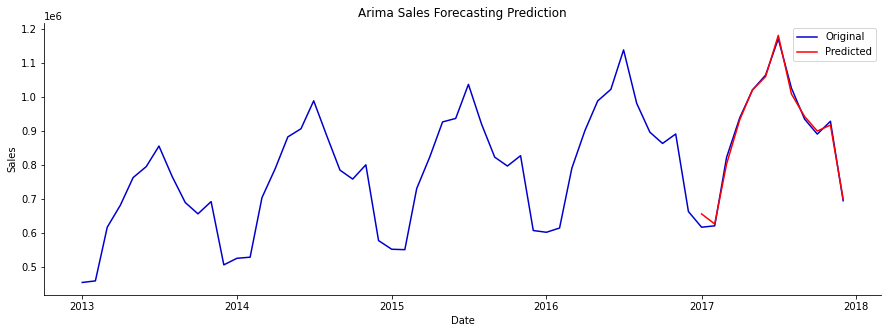

In [31]:
prediction_df, original_df = predict_sarima_df(predictions)
plot_sarima_results(prediction_df, original_df, 'Arima')

In [34]:
def create_results_df():
    results_dict = pickle.load(open("/content/drive/MyDrive/Sales_Prediction/model_scores.p", "rb"))
    results_dict.update(pickle.load(open("/content/drive/MyDrive/Sales_Prediction/arima_model_scores.p", "rb")))
    restults_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['RMSE', 'MAE','R2'])
    restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    return restults_df

In [35]:
results = create_results_df()
results

,index,RMSE,MAE,R2
0,LSTM,17327.679629,13609.666667,0.989406
1,LinearRegression,16221.040791,12433.000000,0.990716
2,ARIMA,14959.893467,11265.335748,0.983564


In [36]:
def plot_results(results_df):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, label='RMSE', color='mediumblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model", ylabel = "Scores", title = "Model Error Comparison")
    sns.despine()
    
    plt.savefig(f'/content/drive/MyDrive/Sales_Prediction/Result_Images/compare_models.png')

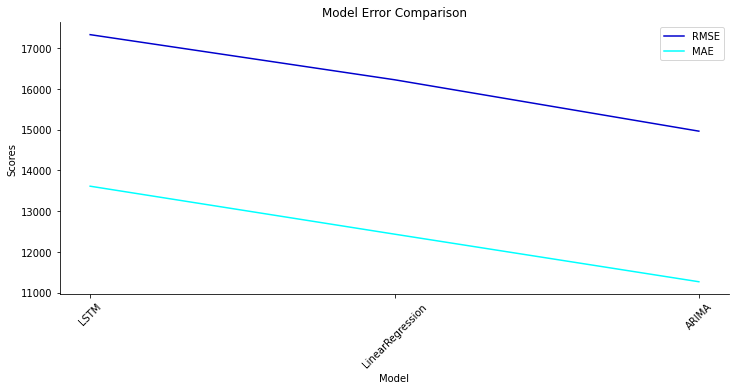

In [37]:
plot_results(results)